In [1]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from market_data.market_data import get_daily_stats
import os
%matplotlib inline

In [2]:
#sim = pd.read_csv('c:/temp/SIM_RESULTS_12_19_ENRICHED.csv')
FNAME = 'c:/temp/SIM_RESULTS_01_04'
if os.path.exists(f'{FNAME}_ENRICHED.csv'):
    print(f'Using cached file {FNAME}_ENRICHED.csv')
    sim = pd.read_csv(f'{FNAME}_ENRICHED.csv')
    sim['date']=pd.to_datetime(sim['date'])
    #Impute missing values with averages ( not great but not terrible )
    for col in 'ar_vol ar_beta ADV ADVD'.split():
        sim[col].fillna((sim[col].mean()), inplace=True)
    print(sim.columns)

else:
    #Read results of the simulation. Add some columns
    #sim = pd.read_csv('c:/temp/SIM_RESULTS_12_8.csv')
    print(f'Reading basic file {FNAME}.csv')
    sim = pd.read_csv(f'{FNAME}.csv')
    sim['date']=pd.to_datetime(sim['date'])
    daily_stats = get_daily_stats(sim)
    sim=sim.merge(daily_stats,on=['sym','date'],how='left')
    sim['ew_return']=sim.c2cdn*np.sign(sim.predicted_c2cdn) ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
    sim['ewo_return']=sim.o2cdn*np.sign(sim.predicted_c2cdn)  ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
                                                              ## more realistic -assumes we open MOO positions based on prev close pricing
    sim['P'] = sim.model_order.apply(lambda x: eval(x)[0])
    sim['Q'] = sim.model_order.apply(lambda x: eval(x)[-1])
    sim['predicted_tstat'] = sim.predicted_c2cdn.abs()/sim.predicted_se ##Certainty of our prediction - unsigned
    sim['abs_predicted_c2cdn'] = sim.predicted_c2cdn.abs() ##Strength of our prediction - unsigned

    sim.to_csv(f'{FNAME}_ENRICHED.csv')
print('SHAPE', sim.shape)
print('COLUMNS', sim.columns)

sim.head(2)


Using cached file c:/temp/SIM_RESULTS_01_04_ENRICHED.csv
Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'sym', 'adjusted_close', 'o2c',
       'prev_close', 'c2c', 'benchmark', 'c2cb', 'o2cb', 'bpc', 'c2cdn',
       'o2cdn', 'predicted_c2cdn', 'predicted_se', 'model_order', 'ar_vol',
       'ar_beta', 'ADV', 'ADVD', 'ew_return', 'ewo_return', 'P', 'Q',
       'predicted_tstat', 'abs_predicted_c2cdn'],
      dtype='object')
SHAPE (994007, 27)
COLUMNS Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'sym', 'adjusted_close', 'o2c',
       'prev_close', 'c2c', 'benchmark', 'c2cb', 'o2cb', 'bpc', 'c2cdn',
       'o2cdn', 'predicted_c2cdn', 'predicted_se', 'model_order', 'ar_vol',
       'ar_beta', 'ADV', 'ADVD', 'ew_return', 'ewo_return', 'P', 'Q',
       'predicted_tstat', 'abs_predicted_c2cdn'],
      dtype='object')


,Unnamed: 0.1,Unnamed: 0,date,sym,adjusted_close,o2c,prev_close,c2c,benchmark,c2cb,...,ar_vol,ar_beta,ADV,ADVD,ew_return,ewo_return,P,Q,predicted_tstat,abs_predicted_c2cdn
0,0,0,2007-07-02,ABBC,9.64,-0.011282,9.55,0.009424,SPY,0.009041,...,0.018646,0.839000,49440.0,511699.7,-0.000383,0.01738,1,1,0.141301,0.001687
1,1,1,2007-07-03,ABBC,9.69,-0.008188,9.64,0.005187,SPY,0.003623,...,0.018601,0.837517,49600.0,529947.4,-0.001564,0.00924,1,1,0.243918,0.002912


In [3]:
#Add quantiles for certain continuous varibales
q= list(np.arange(0,1.,.1))
for c in  "predicted_tstat ar_beta ar_vol ADV ADVD abs_predicted_c2cdn".split():    
    ##quantiles = sim[c].quantile(q+[1]).values
    labels = [str(int(10*s)) for s in q]
    sim[f'{c}_q']= pd.qcut( sim[c],q+[1],retbins=False,labels=labels)

    ##print the resulting cuts
    #print(sim.groupby(f'{c}_q').agg( { c:[np.mean,np.min, np.max,len] } ))

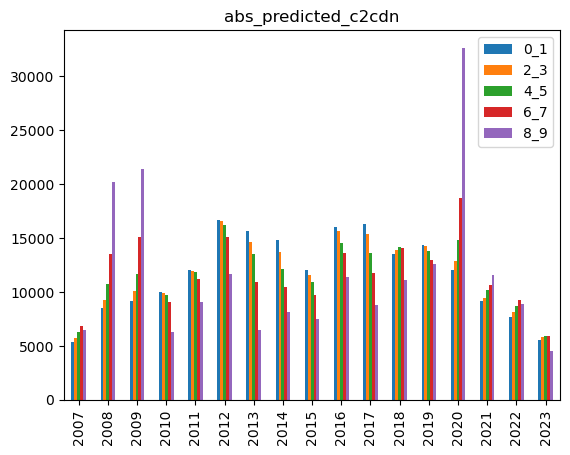

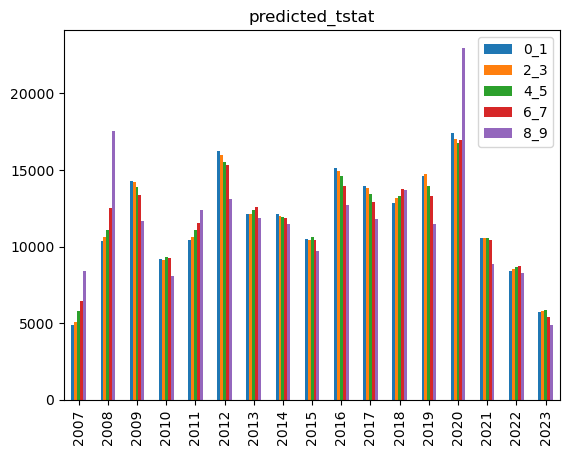

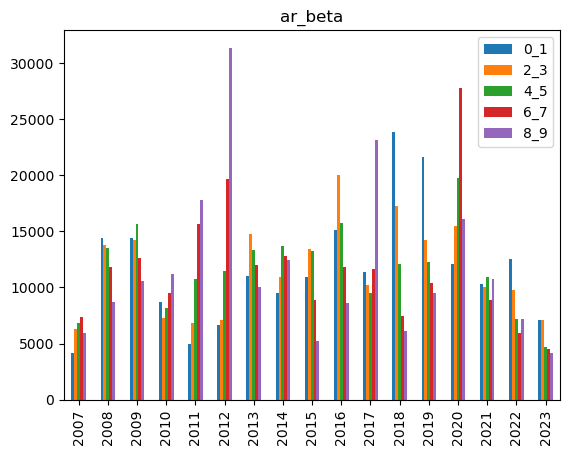

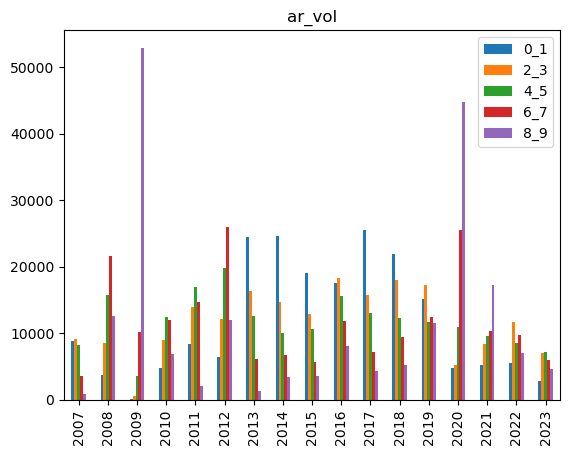

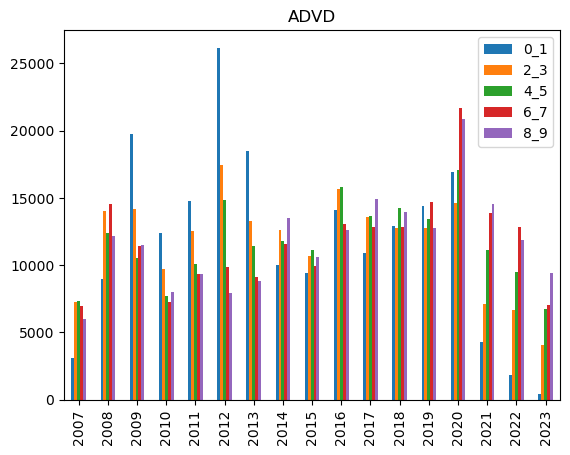

In [4]:
#Demographics by year
for col in  "abs_predicted_c2cdn predicted_tstat ar_beta ar_vol ADVD".split():    
    dates = sorted(sim.date.unique())
    df = pd.DataFrame(index=dates)
    groups = [[0,1],[2,3],[4,5],[6,7],[8,9]]
    for g in groups:
            df[ f'{g[0]}_{g[-1]}' ] = sim[ sim[col+'_q'].isin([str(x) for x in g])].groupby('date')['sym'].count()
    df.fillna(0,inplace=True)
    df = df.groupby(df.index.year).sum()
    df.plot.bar(stacked=False,title=col)
    plt.show()

In [5]:
for col in  "abs_predicted_c2cdn predicted_tstat ar_beta ar_vol ADVD".split():    
    stats=sim.groupby(sim[col+'_q']).agg({'ew_return':[np.mean,np.std,min,max],col: [np.min,np.max],
                                         'ewo_return': [np.mean]})
    with pd.option_context('display.float_format', '{:,.4f}'.format):
        print(f'{col} decile stats\n {stats}\n')


abs_predicted_c2cdn decile stats
                       ew_return                       abs_predicted_c2cdn   
                           mean    std     min    max                 min   
abs_predicted_c2cdn_q                                                       
0                        0.0000 0.0191 -0.3992 0.7716              0.0000  \
1                        0.0001 0.0197 -0.4363 0.8651              0.0005   
2                       -0.0000 0.0196 -0.3560 0.7078              0.0010   
3                        0.0001 0.0207 -1.0665 0.5541              0.0016   
4                        0.0003 0.0255 -0.7837 4.3344              0.0022   
5                        0.0002 0.0227 -0.6127 0.5287              0.0029   
6                        0.0004 0.0242 -0.5859 0.6671              0.0038   
7                        0.0005 0.0266 -0.6088 0.7620              0.0050   
8                        0.0009 0.0306 -1.1352 1.1404              0.0068   
9                        0.0023 0.0439 -0.

In [6]:
features = ['predicted_c2cdn','predicted_se','P','Q','predicted_tstat','ar_vol','ar_beta','ADVD']
X = sim[features]
Y = sim['ew_return']
ct = make_column_transformer( (OneHotEncoder(),['model_order']),remainder="passthrough")
rf = RandomForestRegressor(n_estimators=100,max_depth=4,verbose=True)
#pipe = make_pipeline(ct,rf)
#pipe = make_pipeline(rf)
#pipe.fit(X,Y)
rf.fit(X,Y)
from sklearn.metrics import r2_score
print(f'R2 score {r2_score(Y, rf.predict(X))} ') 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


R2 score 0.025045693178347372 


<center> Feature Importance </center>

In [7]:
#fn = ct.get_feature_names_out()
fn = features
fi = rf.feature_importances_
fi_df = pd.DataFrame({'feature':fn,'importance':fi})
fi_df.sort_values('importance', ascending=False,inplace=True)
fi_df

,feature,importance
0,predicted_c2cdn,0.308092
6,ar_beta,0.293401
5,ar_vol,0.194429
4,predicted_tstat,0.145956
7,ADVD,0.037848
1,predicted_se,0.018710
2,P,0.001563
3,Q,0.000000


ALPHA(BPS) for predicted_tstat_q vs abs_predicted_c2cdn_q


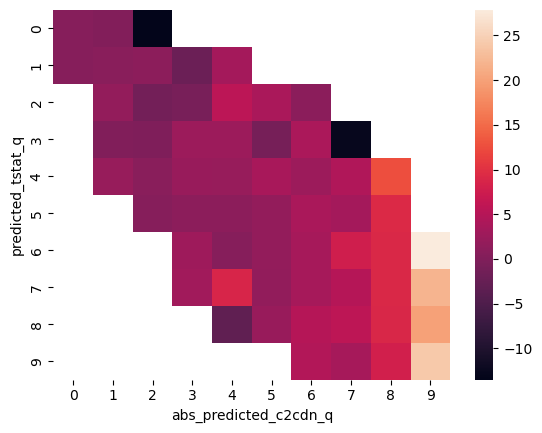

abs_predicted_c2cdn_q    0    1      2     3     4     5    6      7     8   
predicted_tstat_q                                                            
0                     0.42 0.21 -13.49   NaN   NaN   NaN  NaN    NaN   NaN  \
1                     0.46 0.73   1.08 -2.09  3.32   NaN  NaN    NaN   NaN   
2                      NaN 1.76  -1.22 -0.88  5.57  3.83 0.91    NaN   NaN   
3                      NaN 0.04  -0.17  2.63  2.65 -1.05 4.08 -12.83   NaN   
4                      NaN 2.15   0.84  2.31  2.07  3.68 2.50   4.49 12.64   
5                      NaN  NaN   0.50  1.17  1.06  1.83 3.88   3.44  9.25   
6                      NaN  NaN    NaN  2.70  0.53  1.73 3.57   7.67  9.03   
7                      NaN  NaN    NaN  3.08  8.67  1.60 3.58   4.99  9.08   
8                      NaN  NaN    NaN   NaN -3.17  2.30 4.95   5.80  8.92   
9                      NaN  NaN    NaN   NaN   NaN   NaN 4.63   3.59  7.95   

abs_predicted_c2cdn_q     9  
predicted_tstat_q            
0  

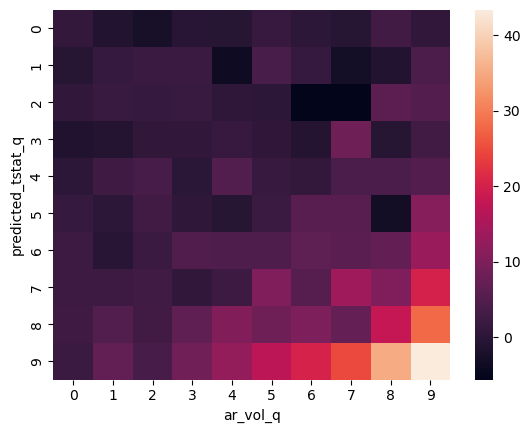

ar_vol_q              0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                  0.90 -1.05 -2.51 -0.33 -0.46  1.58  0.31 -0.49  2.83  0.80
1                 -0.62  1.33  1.89  1.99 -3.77  3.81  1.40 -3.05 -1.05  4.28
2                  0.82  1.66  1.42  1.71  0.41  0.18 -5.62 -5.57  6.10  5.00
3                 -1.37 -0.85  0.76  0.86  1.64  0.51 -0.92  8.08 -0.59  2.91
4                  0.22  2.56  3.67 -0.14  4.72  1.61  0.96  4.04  3.96  4.98
5                  1.31  0.14  2.98  0.35 -0.59  1.96  5.78  5.65 -3.16 10.86
6                  2.06 -0.37  1.95  4.57  4.45  4.51  6.37  6.04  6.81 13.19
7                  2.34  2.20  2.79  0.77  2.16 10.09  5.30 13.57 10.14 20.11
8                  2.58  4.88  2.82  6.44 10.37  7.96  9.92  7.18 18.03 27.89
9                  1.96  6.79  3.66  8.44 12.51 17.09 20.27 24.58 35.26 43.31
COUNTS for predicted_tstat_q vs ar_vol_q
ar_vol_q               

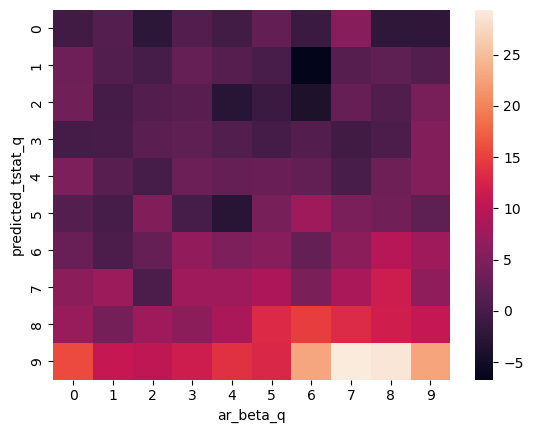

ar_beta_q             0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                 -0.49  1.21 -2.38  1.17 -0.36  2.58 -1.22  5.57 -2.24 -2.11
1                  3.52  1.03  0.01  2.73  1.41  0.21 -6.72  1.33  2.05  1.01
2                  3.62 -0.16  1.07  1.52 -2.82 -1.10 -3.92  2.73  0.85  4.32
3                 -0.17  0.05  1.77  2.25  0.95 -0.17  1.13 -0.51  0.50  5.20
4                  4.83  1.53  0.01  3.22  2.74  3.06  2.31  0.25  3.33  5.33
5                  1.19 -0.09  5.02 -0.01 -2.77  4.26  7.51  4.48  3.77  2.05
6                  2.88  0.59  2.79  6.53  4.81  5.67  2.66  6.09  9.54  7.44
7                  6.08  7.34  0.35  7.47  7.50  8.74  4.61  8.48 11.57  6.27
8                  7.09  4.03  7.59  5.90  8.48 13.14 14.76 13.23 11.80 10.72
9                 15.82 10.78 10.27 11.56 13.85 12.91 22.95 29.37 28.93 22.83
COUNTS for predicted_tstat_q vs ar_beta_q
ar_beta_q             

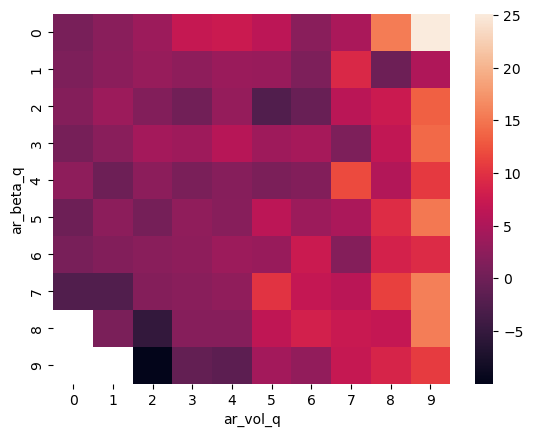

ar_vol_q      0     1     2     3     4     5     6     7     8     9
ar_beta_q                                                            
0          0.82  2.10  3.60  7.10  7.52  6.29  2.18  4.79 15.48 25.10
1          1.16  2.21  3.21  2.50  3.56  3.33  1.22  9.13 -0.17  5.21
2          1.68  3.60  1.55  0.27  3.15 -2.57 -0.57  6.16  7.52 13.37
3          0.61  2.11  4.28  3.73  5.84  3.80  4.48  1.25  6.65 14.10
4          2.52 -0.13  2.42  0.91  1.88  0.98  1.61 11.86  5.41 10.69
5         -0.20  2.44  0.45  2.68  2.07  6.24  3.64  4.95  9.57 15.11
6          0.74  1.55  2.08  2.52  3.63  3.39  7.49  1.78  8.42  9.41
7         -2.49 -2.52  1.76  2.09  2.73 10.14  6.90  6.17 11.14 15.75
8           NaN  0.89 -5.32  1.86  1.93  6.53  8.32  7.35  6.89 15.54
9           NaN   NaN -9.98 -0.96 -1.55  4.18  2.86  7.12  8.68 10.78
COUNTS for ar_beta_q vs ar_vol_q
ar_vol_q       0      1      2      3      4      5      6      7      8   
ar_beta_q                                          

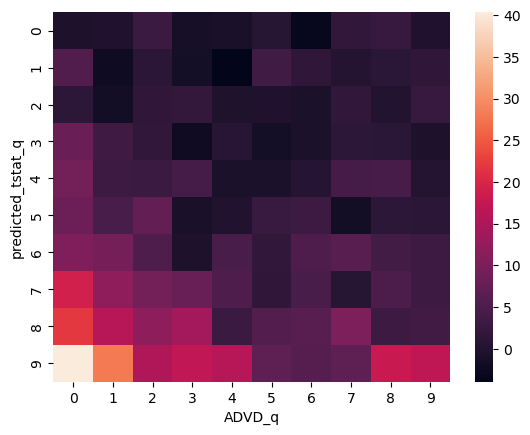

ADVD_q                0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                 -0.50 -0.27  2.95 -1.21 -0.91  0.56 -3.12  1.85  2.50 -0.16
1                  5.27 -2.23  1.12 -1.55 -3.96  3.49  1.71  0.20  1.02  1.59
2                  1.31 -1.77  1.70  2.04 -0.45 -0.26 -0.75  1.76  0.05  2.60
3                  8.14  3.36  1.81 -2.06  0.86 -1.56 -0.80  1.30  0.95 -0.51
4                  9.20  3.02  2.91  4.02 -0.74 -0.79  0.44  4.05  4.47  0.21
5                  8.23  4.61  7.35 -0.85 -0.11  2.68  3.04 -1.85  1.39  1.08
6                 10.27  9.25  5.15 -0.56  4.60  1.84  5.17  6.17  3.96  3.27
7                 19.24 12.11  9.09  7.83  5.19  1.71  4.66  0.68  5.01  3.07
8                 21.95 16.05 11.92 13.98  2.86  5.67  6.14 10.12  3.02  3.77
9                 40.36 27.93 15.29 17.16 15.97  6.91  5.97  6.81 18.00 16.86
COUNTS for predicted_tstat_q vs ADVD_q
ADVD_q                 0 

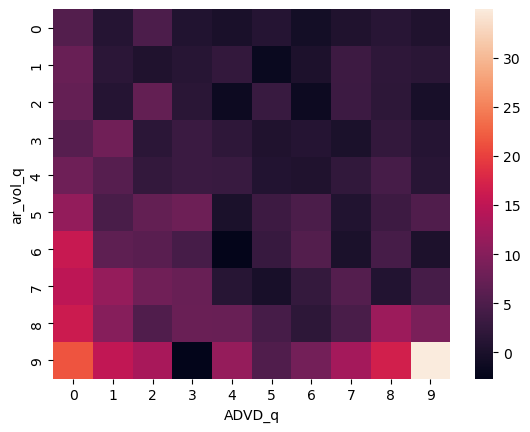

ADVD_q       0     1     2     3     4     5     6     7     8     9
ar_vol_q                                                            
0         5.42  1.08  4.86  0.69 -0.05  1.08 -0.74  0.49  1.33  0.49
1         7.38  1.62  0.56  1.19  2.35 -1.65  0.15  3.43  1.92  1.58
2         7.16  1.14  6.92  1.59 -1.43  2.98 -1.47  3.26  1.87 -0.25
3         5.71  8.14  1.69  3.09  1.96  0.45  1.04  0.02  2.33  1.01
4         7.97  5.74  2.44  3.15  2.94  0.81  0.51  2.30  4.29  1.39
5        11.28  4.55  6.96  7.84  0.09  3.40  4.80  0.56  3.40  5.24
6        15.74  6.49  6.14  4.34 -2.49  2.88  5.50  0.07  4.36  0.23
7        14.82 11.33  8.10  7.34  1.23 -0.21  2.56  5.58  0.75  4.38
8        16.24  9.99  5.20  7.48  7.41  4.35  1.86  4.58 11.92  9.02
9        21.44 15.17 12.95 -2.67 11.38  5.22  8.36 12.73 16.83 34.94
COUNTS for ar_vol_q vs ADVD_q
ADVD_q        0      1      2      3      4      5      6      7      8      9
ar_vol_q                                                       

In [8]:
def meaningful_mean(s:pd.Series) :
    if s is None or len(s) < 1000:
        return np.NaN
    else:
        return s.mean()
        
#pairwise heat plot of features
counter=1
for f1,f2 in (['predicted_tstat_q','abs_predicted_c2cdn_q'], ['predicted_tstat_q','ar_vol_q'],['predicted_tstat_q','ar_beta_q'],['ar_beta_q','ar_vol_q'],['predicted_tstat_q','ADVD_q'],['ar_vol_q','ADVD_q']):
    hm = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc=meaningful_mean)
    hmcounts = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc='count')
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(f'ALPHA(BPS) for {f1} vs {f2}' )
        ax = plt.subplot(1,1,1) 
        sns.heatmap(hm*10000,ax=ax)
        counter+=1
        plt.show()
        print(hm*10000)
    with pd.option_context('display.float_format', '{:.0f}'.format):
        print(f'COUNTS for {f1} vs {f2}' )
        print(hmcounts)


OVERALL ALPHA 4.33 bps, CNT 4113 STD 27.42 STD- 16.94bps STD+ 16.94bps sharpe 0.16 sortino 0.26
TS=4 ALPHA 3.04 bps, CNT 4113 STD 55.41 STD- 36.03bps STD+ 36.03bps sharpe 0.05 sortino 0.08
TS=6 ALPHA 4.33 bps, CNT 4113 STD 57.71 STD- 41.12bps STD+ 41.12bps sharpe 0.08 sortino 0.11
TS=7 ALPHA 6.34 bps, CNT 4113 STD 65.91 STD- 42.95bps STD+ 42.95bps sharpe 0.10 sortino 0.15
TS=9 ALPHA 12.03 bps, CNT 4112 STD 85.85 STD- 56.22bps STD+ 56.22bps sharpe 0.14 sortino 0.21
TS=0 ALPHA -0.08 bps, CNT 4113 STD 52.46 STD- 37.06bps STD+ 37.06bps sharpe -0.00 sortino -0.00
TS=1 ALPHA 0.39 bps, CNT 4113 STD 55.40 STD- 43.55bps STD+ 43.55bps sharpe 0.01 sortino 0.01
TS=8 ALPHA 8.36 bps, CNT 4113 STD 66.56 STD- 44.11bps STD+ 44.11bps sharpe 0.13 sortino 0.19
TS=5 ALPHA 2.13 bps, CNT 4113 STD 55.94 STD- 41.07bps STD+ 41.07bps sharpe 0.04 sortino 0.05
TS=2 ALPHA 0.65 bps, CNT 4113 STD 55.31 STD- 40.32bps STD+ 40.32bps sharpe 0.01 sortino 0.02
TS=3 ALPHA 0.85 bps, CNT 4113 STD 54.63 STD- 38.47bps STD+ 38.4

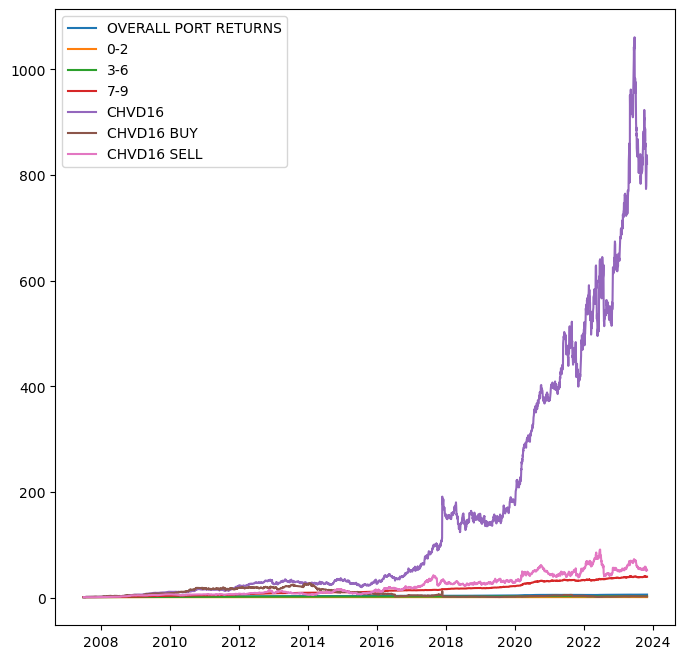

In [9]:
#Overall
def printstats(lbl,drets):
    alpha = drets.mean()
    std = drets.std()
    stdneg = drets[drets<0].std()
    stdpos = drets[drets>=0].std()
    sharpe = alpha/std
    sortino = alpha/stdneg
    
    print(f'{lbl} ALPHA {alpha*10000:.2f} bps, CNT {len(drets):.0f} STD { std*10000:.2f} STD- { stdneg*10000:.2f}bps STD+ { stdneg*10000:.2f}bps sharpe { sharpe:.2f} sortino { sortino:.2f}' )
drets = sim.groupby('date')['ew_return'].mean()
printstats('OVERALL', drets)
for ts in sim['predicted_tstat_q'].unique():
    drets = sim[sim.predicted_tstat_q==ts].groupby('date')['ew_return'].mean()
    printstats(f'TS={ts}',drets)


fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,1,2],[3,4,5,6],[7,8,9]]
for grp in grps:
    pass
    pi = (1+sim[sim.predicted_tstat_q.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')

#for th in [50,70,90]:
#    combo = (1+sim[(sim.TS.astype(float)>=th) & (sim.arvol_quantile.astype(float)>=th)].groupby('date')['ew_return'].mean()).cumprod()
#    plt.plot(combo,label= f'CHV{th}')

for th in [16]: #[80,100,120,160]:
    combo = (1+sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(combo,label= f'CHVD{th}')
#Conviction Hi Vol Diagonal 160 decomposed into buys and sells
th=16
chvdb = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn>0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvdb,label= f'CHVD{th} BUY')
chvds = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn<0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvds,label= f'CHVD{th} SELL')


plt.legend()
plt.show()

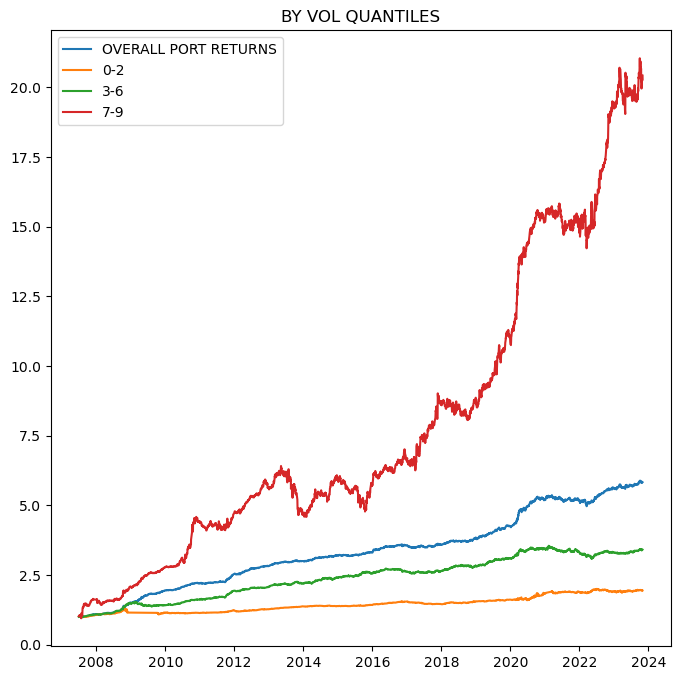

In [10]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,1,2],[3,4,5,6],[7,8,9]]
for grp in grps:
    pi = (1+sim[sim.ar_vol_q.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')
plt.legend()
plt.title('BY VOL QUANTILES')
plt.show()

In [11]:
def sharpes(s):
    sh = s.mean()/s.std()
    so = s.mean()/s[s<0].std()
    return sh,so
    
#hiconv trades
grps = [[],[0,1,2],[3,4,5,6,7,8,9],[3,4,5,6],[7,8,9],[9]]
for grp in grps:
    hc = sim[sim.ar_vol_q.isin([(str(g)) for g in grp])] if len(grp) else sim
    print(f'\nGroup {grp} len {len(hc)}')
          
    #hc = sim[sim.TS.isin(['70','80','90'])]
    #winners/losers by trade
    print(f'By trade winners - {len(hc[hc.ew_return>0])} losers {len(hc[hc.ew_return<0])} ')
    bysym = hc.groupby(hc.sym)['ew_return'].mean()
    print(f'By sym winners - {len(bysym[bysym>0])} losers {len(bysym[bysym<0])} ')
    
    bydate = hc.groupby(hc.date)['ew_return'].mean()
    bydatedf = bydate.reset_index()
    print(f'By date winners - {len(bydate[bydate>0])} losers {len(bydate[bydate<0])} sharpe/sort {sharpes(bydate)}')
    #bymonth = hc.groupby(hc.date.dt.to_period("M"))['ew_return'].mean()
    bymonth = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('M'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By bymonth winners - {len(bymonth[bymonth>0])} losers {len(bymonth[bymonth<0])} sharpe/sort {sharpes(bymonth)}')
    #byq = hc.groupby(hc.date.dt.to_period("Q"))['ew_return'].mean()
    byq = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('Q'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By byq winners - {len(byq[byq>0])} losers {len(byq[byq<0])} sharpe/sort {sharpes(byq)}')



Group [] len 994007
By trade winners - 506141 losers 487821 
By sym winners - 2595 losers 2097 
By date winners - 2347 losers 1766 sharpe/sort (0.15776133865747521, 0.25536106676210935)
By bymonth winners - 153 losers 43 sharpe/sort (0.6250995451982504, 1.935833854519748)
By byq winners - 56 losers 10 sharpe/sort (0.7846410395156026, 3.7815111593607598)

Group [0, 1, 2] len 298202
By trade winners - 151166 losers 147024 
By sym winners - 1132 losers 1096 
By date winners - 2085 losers 1749 sharpe/sort (0.0518989227067769, 0.06083483097934382)
By bymonth winners - 119 losers 65 sharpe/sort (0.2579551809554671, 0.2787999975647399)
By byq winners - 46 losers 17 sharpe/sort (0.4182833423867776, 0.6565493548873631)

Group [3, 4, 5, 6, 7, 8, 9] len 695805
By trade winners - 354975 losers 340797 
By sym winners - 2462 losers 2011 
By date winners - 2324 losers 1789 sharpe/sort (0.14586409815701773, 0.24023271240865907)
By bymonth winners - 149 losers 47 sharpe/sort (0.6203354987846713, 1.702

     ew_return                      
          mean    std    len std_err
date                                
1       0.0006 0.0277  30539  0.0002
2       0.0006 0.0261  32417  0.0001
3       0.0003 0.0282  32251  0.0002
4       0.0001 0.0259  30633  0.0001
5       0.0004 0.0268  32047  0.0001
6       0.0003 0.0273  33240  0.0001
7       0.0004 0.0248  32851  0.0001
8       0.0003 0.0272  33830  0.0001
9       0.0005 0.0277  34148  0.0001
10      0.0008 0.0291  33220  0.0002
11      0.0004 0.0255  33717  0.0001
12      0.0005 0.0241  33392  0.0001
13      0.0008 0.0261  34040  0.0001
14      0.0008 0.0227  33613  0.0001
15      0.0006 0.0236  32716  0.0001
16      0.0003 0.0245  32770  0.0001
17      0.0003 0.0256  33113  0.0001
18      0.0001 0.0275  32061  0.0002
19      0.0006 0.0271  32211  0.0002
20      0.0004 0.0252  32537  0.0001
21      0.0008 0.0240  32414  0.0001
22      0.0005 0.0243  32879  0.0001
23      0.0003 0.0244  33860  0.0001
24      0.0005 0.0348  32886  0.0002
2

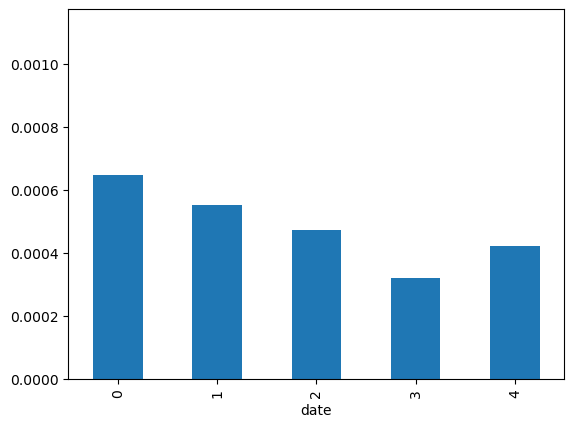

In [12]:
#Is there a day of month effect ( which could be because we recalbrate monthly )
bydayOfMonth = sim.groupby(sim['date'].dt.day).agg({'ew_return':[np.mean,np.std,len]})
bydayOfMonth[('ew_return','std_err')] = bydayOfMonth[('ew_return','std')]/np.sqrt(bydayOfMonth[('ew_return','len')])
bydayOfWeek = sim.groupby(sim['date'].dt.dayofweek).agg({'ew_return':[np.mean,np.std,len]})
bydayOfWeek[('ew_return','std_err')] = bydayOfWeek[('ew_return','std')]/np.sqrt(bydayOfWeek[('ew_return','len')])

with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(bydayOfMonth)
    print(bydayOfWeek)

print(bydayOfMonth[('ew_return','mean')].plot.bar())
print(bydayOfWeek[('ew_return','mean')].plot.bar())


In [13]:
### Dynamic notional allocation scheme that takes into account predicted_tstat_q, ar_vol_q and beta to allocate dollars by trade
def getAllocationWeights(mults:np.ndarray):
    tstatMultipliers,volMultipliers,betaMultipliers,advdMultipliers,abspMultipliers = \
        mults[0:10],mults[10:20],mults[20:30],mults[30:40],mults[40:50]
    PREDICTED_TSTAT_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],tstatMultipliers))
    AR_VOL_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],  volMultipliers))
    AR_BETA_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], betaMultipliers))
    ADVD_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], advdMultipliers))
    ABS_PRED_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], abspMultipliers))
    t1 = sim['predicted_tstat_q'].map(PREDICTED_TSTAT_Q_MULTIPLIER).astype(float)
    t2 = sim['ar_vol_q'].map(AR_VOL_Q_MULTIPLIER).astype(float)
    t3 = sim['ar_beta_q'].map(AR_BETA_Q_MULTIPLIER).astype(float)
    t4 = sim['ADVD_q'].map(ADVD_Q_MULTIPLIER).astype(float)
    t5 = sim['abs_predicted_c2cdn_q'].map(ABS_PRED_Q_MULTIPLIER).astype(float)
    score = t1*t2*t3*t5*t5
    dailyScore = score.groupby(sim.date).sum()
    dailyScore.name='dailyScore'
    allocationWeight=score/sim.merge(dailyScore, on='date',how='left')['dailyScore']
    return allocationWeight
    
GLOBAL_COUNTER=0
def getSortino(mults:np.ndarray,verbose=False)->int:
    #print(f'Invoked with {mults}')
    global GLOBAL_COUNTER
    allocationWeight = getAllocationWeights(mults)
    dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
    sortino =  dynamicReturns.mean()/dynamicReturns[dynamicReturns<0].std() #sortino
    sharpe =  dynamicReturns.mean()/dynamicReturns.std() #sharpe
    if verbose or GLOBAL_COUNTER % 100 == 0:
        print( f'{GLOBAL_COUNTER} ALPHA { 10000*dynamicReturns.mean():.2f}bps SORTINO {sortino:.4f} SHARPE {sharpe:.4f}' )
    GLOBAL_COUNTER+=1
    return sortino
        
def getSortinoInverse(mults)->int:
    return 1./getSortino(mults)
    

In [18]:
#getSharpe([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4.],[ .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
#getSharpe(np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.]))
from scipy.optimize import minimize
#initialGuess = np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
initialGuess = np.array([.1]*50)
bounds = [(0,None) for v in initialGuess]
GLOBAL_COUNTER=0
solution = minimize(getSortinoInverse,tol=0.0001,x0=initialGuess,bounds=bounds,options={'disp':True, 'maxiter':10000})
mults = solution.x
print('TSTAT VOL BETA ADV APRED')
for i in range(10):
    print(f'{mults[i]:.2f} {mults[i+10]:.2f} {mults[i+20]:.2f} {mults[i+30]:.2f} {mults[i+40]:.2f}')


0 ALPHA 4.33bps SORTINO 0.2554 SHARPE 0.1578
100 ALPHA 14.69bps SORTINO 0.1826 SHARPE 0.1233
200 ALPHA 9.85bps SORTINO 0.2855 SHARPE 0.1679
300 ALPHA 6.77bps SORTINO 0.3125 SHARPE 0.1865
400 ALPHA 7.87bps SORTINO 0.3243 SHARPE 0.1902
500 ALPHA 8.35bps SORTINO 0.3328 SHARPE 0.1920
600 ALPHA 8.41bps SORTINO 0.3351 SHARPE 0.1919
700 ALPHA 8.28bps SORTINO 0.3368 SHARPE 0.1918
800 ALPHA 8.30bps SORTINO 0.3382 SHARPE 0.1921
900 ALPHA 8.31bps SORTINO 0.3385 SHARPE 0.1919
TSTAT VOL BETA ADV APRED
0.12 0.11 0.16 0.10 0.06
0.03 0.18 0.05 0.10 0.24
0.11 0.12 0.04 0.10 0.00
0.09 0.20 0.14 0.10 0.12
0.10 0.07 0.14 0.10 0.01
0.00 0.16 0.04 0.10 0.08
0.18 0.13 0.12 0.10 0.19
0.14 0.06 0.15 0.10 0.15
0.14 0.07 0.17 0.10 0.24
0.20 0.04 0.04 0.10 0.25


In [15]:
allocationWeight = getAllocationWeights(solution.x)
dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
#multDR = (1+dynamicReturns)
#multDR.groupby([multDR.index.year,multDR.index.month]).prod().apply([np.mean,np.std])
annualized = dynamicReturns.groupby([dynamicReturns.index.year]).sum() ## No re-investment / compounding
annualized.mean()/annualized.std()


1.3873272517875417

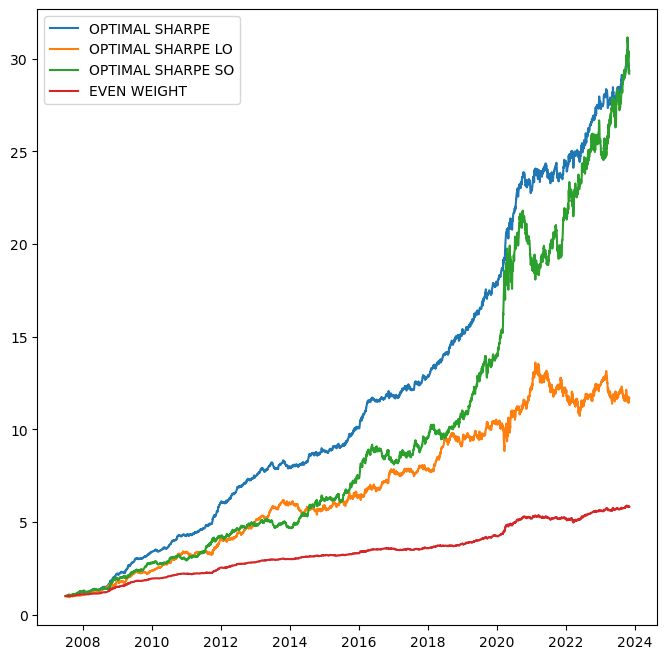

In [16]:
allocationWeight = getAllocationWeights(solution.x)
allocationWeightLO = allocationWeight[np.sign(sim.predicted_c2cdn)==1]
allocationWeightLO=allocationWeightLO/allocationWeightLO.groupby(sim.date).transform(sum)

allocationWeightSO = allocationWeight[np.sign(sim.predicted_c2cdn)==-1]
allocationWeightSO=allocationWeightSO/allocationWeightSO.groupby(sim.date).transform(sum)

dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsLO = (allocationWeightLO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsSO = (allocationWeightSO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()


simpleReturns = (sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).mean()
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot((1+dynamicReturns).cumprod(),label='OPTIMAL SHARPE')
plt.plot((1+dynamicReturnsLO).cumprod(),label='OPTIMAL SHARPE LO')
plt.plot((1+dynamicReturnsSO).cumprod(),label='OPTIMAL SHARPE SO')
plt.plot((1+simpleReturns).cumprod(),label='EVEN WEIGHT')
#High rish strategy
hiRiskTrades = sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=16]
hiRiskReturns = hiRiskTrades.groupby('date')['ew_return'].mean()
#plt.plot((1+hiRiskReturns).cumprod(),label='HI RISK')

plt.legend()
plt.show()

In [23]:
with pd.option_context('display.max_columns', 50):
    display(sim.head())


,Unnamed: 0.1,Unnamed: 0,date,sym,adjusted_close,o2c,prev_close,c2c,benchmark,c2cb,o2cb,bpc,c2cdn,o2cdn,predicted_c2cdn,predicted_se,model_order,ar_vol,ar_beta,ADV,ADVD,ew_return,ewo_return,P,Q,predicted_tstat,abs_predicted_c2cdn,predicted_tstat_q,ar_beta_q,ar_vol_q,ADV_q,ADVD_q,abs_predicted_c2cdn_q
0,0,0,2007-07-02,ABBC,9.64,-0.011282,9.55,0.009424,SPY,0.009041,0.006098,109.718201,0.000383,-0.017380,-0.001687,0.011939,"(1, 0, 1)",0.018646,0.839000,49440.0,511699.70,-0.000383,0.017380,1,1,0.141301,0.001687,4,2,2,1,1,3
1,1,1,2007-07-03,ABBC,9.69,-0.008188,9.64,0.005187,SPY,0.003623,0.001051,110.710197,0.001564,-0.009240,-0.002912,0.011939,"(1, 0, 1)",0.018601,0.837517,49600.0,529947.40,-0.001564,0.009240,1,1,0.243918,0.002912,6,2,2,1,1,5
2,2,2,2007-07-05,ABBC,9.84,0.016529,9.69,0.015480,SPY,-0.001050,-0.001444,111.111298,0.016530,0.017972,-0.003151,0.011939,"(1, 0, 1)",0.018603,0.840805,51360.0,539102.44,-0.016530,-0.017972,1,1,0.263945,0.003151,7,2,2,1,1,5
3,3,3,2007-07-06,ABBC,9.89,0.007128,9.84,0.005081,SPY,0.005257,0.003937,110.994598,-0.000176,0.003191,-0.006082,0.011939,"(1, 0, 1)",0.018575,0.834053,58080.0,646140.00,0.000176,-0.003191,1,1,0.509395,0.006082,9,2,2,1,1,7
4,4,4,2007-07-09,ABBC,9.76,-0.005097,9.89,-0.013145,SPY,0.000131,-0.001045,111.578102,-0.013275,-0.004052,-0.002832,0.011939,"(1, 0, 1)",0.018587,0.837072,62080.0,684432.00,0.013275,0.004052,1,1,0.237171,0.002832,6,2,2,1,1,4


In [44]:
allocationWeight = getAllocationWeights(solution.x)

bySim = (np.sign(sim.predicted_c2cdn) * sim.c2cdn).groupby([sim.sym,sim.date.dt.year]).agg( samples=len,rtrn=np.mean )
bySim.sort_values('rtrn',inplace=True)
bySim.to_csv('c:/temp/bysim.csv')

